In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from create_matrix import *
import os
import sys
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse_fraction
from common import compute_rmse

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
year = 2014
n_splits = 10
case=2
a=2
cost='abs'

In [4]:
def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [108]:
def learn_HAT_constant(case, E_np_masked, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='abs', H_known=None,
              A_known=None, T_known=None):
    np.random.seed(0)
    if cost_function == 'abs':
        cost = cost_abs
    else:
        cost = cost_rel
    mg = multigrad(cost, argnums=[0, 1, 2])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    H = np.random.rand(*H_dim)

    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)

    T[:,0] = 1
    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, E_np_masked, case)
        H -= lr * del_h
        A -= lr * del_a
        T -= lr * del_t
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        # Projection to non-negative space
        H[H < 0] = 0
        A[A < 0] = 0
        T[T < 0] = 0
        T[:,0] = 1
#         print T
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, E_np_masked, case))
    return H, A, T


In [6]:
region = "SanDiego"
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
region = "Austin"
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

## Learn H, A, T from Austin

In [7]:
H_a, A_a, T_a = learn_HAT(case, au_tensor, a, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 

### transfer learning with constant

In [ ]:
from scipy.optimize import nnls

pred_transfer_cons = {}
T_adapt_cons = {}
n_splits = 10
case = 2
a = 2
cost = 'abs'


for random_seed in range(10):
    pred_transfer_cons[random_seed] = {}
    T_adapt_cons[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred_transfer_cons[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}


kf = KFold(n_splits=n_splits)
for random_seed in range(5):
    print "random seed: ", random_seed
    for adapt_percentage in range(10, 110, 10):
        print "adapt percentage: ", adapt_percentage
        rd = 0
        T_adapt_cons[random_seed][adapt_percentage] = {}
        for adapt_max, test in kf.split(sd_df):
            print "round: ", rd
            
            
            num_adapt = int((adapt_percentage*len(adapt_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if adapt_percentage == 100:
                adapt = adapt_max
            else:
                adapt, _ = train_test_split(adapt_max, train_size = adapt_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            adapt_ix = sd_df.index[adapt]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            adapt_df = sd_df.ix[adapt_ix]
            test_df = sd_df.ix[test_ix]
            adapt_dfc = sd_dfc.ix[adapt_ix]
            test_dfc = sd_dfc.ix[test_ix]
            adapt_sd_tensor = get_tensor(adapt_df, adapt_dfc)
            
            # use the adpat data with A_au from Austion to learn T_sd_adapt
            H_sd_adapt, A_sd_adapt, T_sd_adapt = learn_HAT_constant(case, adapt_sd_tensor, a, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a)

            T_adapt_cons[random_seed][adapt_percentage][rd] = T_sd_adapt
            rd += 1
            
            # Then we use T_sd_adapt, A_a and aggregate readings to learn H_sd in SanDiego
            test_sd_tensor = get_tensor(test_df, test_dfc)
            # Get the aggregate information of test homes
            aggregate_test = test_sd_tensor[:, 0, :]
            # Use A_au from Austin and T_sd_adapt learn previous
            AT_mat = np.einsum('ab, Ob -> aO', A_a[0], T_sd_adapt)
            
            # Estimate Home factor H_test_mat for test homes
            H_test_mat = np.zeros((len(test_df), 2))
            for j in range(len(test_df)):
                mask_rows = pd.Series(aggregate_test[j,:]).notnull()
                H_test_mat[j,:] = nnls(AT_mat.transpose()[mask_rows], aggregate_test[j,:][mask_rows])[0]
            pred_overall = np.einsum('Ma, Nab, Ob -> MNO', H_test_mat, A_a, T_sd_adapt)
            
            for appliance_name, appliance_id in appliance_index.iteritems():
                pred_transfer_cons[random_seed][appliance_name][adapt_percentage].append(pd.DataFrame(pred_overall[:,appliance_id,:], index=test_df.index))

random seed:  0
adapt percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
adapt percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:

### Tranfer learning with A_au

In [24]:
from scipy.optimize import nnls

pred_transfer = {}
n_splits = 10
case = 2
a = 2
cost = 'abs'


for random_seed in range(5):
    pred_transfer[random_seed] = {}
    T_adapt[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred_transfer[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(5):
    print "random seed: ", random_seed
    for adapt_percentage in range(10, 110, 10):
        print "adapt percentage: ", adapt_percentage
        rd = 0
        T_adapt[random_seed][adapt_percentage] = {}
        for adapt_max, test in kf.split(sd_df):
            print "round: ", rd
            rd += 1
            
            num_adapt = int((adapt_percentage*len(adapt_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if adapt_percentage == 100:
                adapt = adapt_max
            else:
                adapt, _ = train_test_split(adapt_max, train_size = adapt_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            adapt_ix = sd_df.index[adapt]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            adapt_df = sd_df.ix[adapt_ix]
            test_df = sd_df.ix[test_ix]
            adapt_dfc = sd_dfc.ix[adapt_ix]
            test_dfc = sd_dfc.ix[test_ix]
            adapt_sd_tensor = get_tensor(adapt_df, adapt_dfc)
            
            # use the adpat data with A_au from Austion to learn T_sd_adapt
            H_sd_adapt, A_sd_adapt, T_sd_adapt = learn_HAT(case, adapt_sd_tensor, a, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a)
            T_adapt[random_seed][adapt_percentage][rd] = T_sd_adapt

            
            # Then we use T_sd_adapt, A_a and aggregate readings to learn H_sd in SanDiego
            test_sd_tensor = get_tensor(test_df, test_dfc)
            # Get the aggregate information of test homes
            aggregate_test = test_sd_tensor[:, 0, :]
            # Use A_au from Austin and T_sd_adapt learn previous
            AT_mat = np.einsum('ab, Ob -> aO', A_a[0], T_sd_adapt)
            
            # Estimate Home factor H_test_mat for test homes
            H_test_mat = np.zeros((len(test_df), 2))
            for j in range(len(test_df)):
                mask_rows = pd.Series(aggregate_test[j,:]).notnull()
                H_test_mat[j,:] = nnls(AT_mat.transpose()[mask_rows], aggregate_test[j,:][mask_rows])[0]
            pred_overall = np.einsum('Ma, Nab, Ob -> MNO', H_test_mat, A_a, T_sd_adapt)
            
            for appliance_name, appliance_id in appliance_index.iteritems():
                pred_transfer[random_seed][appliance_name][adapt_percentage].append(pd.DataFrame(pred_overall[:,appliance_id,:], index=test_df.index))
            

random seed:  0
adapt percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
adapt percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:

### Normal learning

In [25]:
pred = {}
n_splits = 10
case = 2
a = 2
cost = 'abs'

for random_seed in range(5):
    pred[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(5):
    print "random seed: ", random_seed
    for train_percentage in range(10, 110, 10):
        print "training percentage: ", train_percentage
        rd = 0
        for train_max, test in kf.split(sd_df):
            print "round: ", rd
            rd += 1
            
            num_train = int((train_percentage*len(train_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)
            tensor_copy = tensor.copy()
            # set the appliance consumption to be missing for testing data
            tensor_copy[:num_test, 1:, :] = np.NaN
            # do tensor factorization
            H, A, T = learn_HAT(case, tensor_copy, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost)
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))

random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
te

In [107]:
out_transfer_cons = {}
for random_seed in range(5):
    out_transfer_cons[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer_cons[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer_cons[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer_cons[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer_cons[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [30]:
out_transfer = {}
for random_seed in range(5):
    out_transfer[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [31]:
out = {}
for random_seed in range(5):
    out[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [16]:
out_transfer

{0: {'dw': {10: 1.8642624098584866,
   20: 1.870526132552027,
   30: 1.8610602028685075,
   40: 1.8459849814178813,
   50: 1.8341997743642557,
   60: 1.8308737101393522,
   70: 1.8261521277913977,
   80: 1.8296906439819403,
   90: 1.8178094831637981,
   100: 1.8167408821474742},
  'fridge': {10: 10.615642011294208,
   20: 11.165470537553773,
   30: 11.14547589330922,
   40: 11.268598817233615,
   50: 10.99244237809091,
   60: 10.65855437830518,
   70: 10.491390548893159,
   80: 10.57522787409337,
   90: 10.391560752868749,
   100: 10.326796649231019},
  'hvac': {10: 21.51109406472797,
   20: 18.125592251115268,
   30: 17.372691977076631,
   40: 17.555412837220135,
   50: 17.65091298830049,
   60: 17.076071087503422,
   70: 17.499290915744993,
   80: 18.168280501497176,
   90: 17.651967896987792,
   100: 17.499316530842528},
  'mw': {10: 2.3219770028509545,
   20: 2.313778333778977,
   30: 2.3023122654664125,
   40: 2.2919891803972368,
   50: 2.2865761710912449,
   60: 2.288941796201976

In [103]:
mean_out_transfer = pd.Panel(out_transfer).mean(axis=0)
mean_out_transfer_const = pd.Panel(out_transfer_cons).mean(axis=0)
mean_out_normal = pd.Panel(out).mean(axis=0)

In [104]:
mean_out_transfer

,dw,fridge,hvac,mw,oven,wm
10,1.900700,10.687991,18.898082,2.272884,2.363145,0.953931
20,1.845003,10.744633,17.360707,2.228282,2.258578,0.945991
30,1.837553,10.703311,16.737641,2.211619,2.225029,0.939799
40,1.822103,10.625665,17.181808,2.218375,2.197245,0.928837
50,1.819624,10.487651,17.173355,2.213250,2.175712,0.918199
60,1.809590,10.015600,16.484233,2.214234,2.106191,0.900074
70,1.809677,9.911326,16.771457,2.210997,2.095693,0.895698
80,1.806664,9.959254,16.901571,2.210339,2.087744,0.896844
90,1.806392,9.895565,16.715289,2.208609,2.088767,0.893647
100,1.806072,9.908399,16.510238,2.210948,2.089518,0.892767


In [105]:
# df_out_normal = pd.DataFrame(out_normal)]
mean_out_normal = mean_out_normal.rename(columns={'dw':'dw_normal', 'fridge':'fridge_normal', 'hvac':'hvac_normal',
                                             'mw':'mw_normal', 'oven':"oven_normal", 'wm':'wm_normal'})
mean_out_transfer = mean_out_transfer.rename(columns={'dw':'dw_transfer', 'fridge':'fridge_transfer', 'hvac':'hvac_transfer',
                                             'mw':'mw_transfer', 'oven':"oven_transfer", 'wm':'wm_transfer'})
mean_out_transfer_const = mean_out_transfer_const.rename(columns={'dw':'dw_transfer_const', 'fridge':'fridge_transfer_const', 'hvac':'hvac_transfer_const',
                                             'mw':'mw_transfer_const', 'oven':"oven_transfer_const", 'wm':'wm_transfer_const'})

all_out = pd.concat([mean_out_normal, mean_out_transfer], axis=1)
all_out = pd.concat([all_out, mean_out_transfer_const], axis=1)


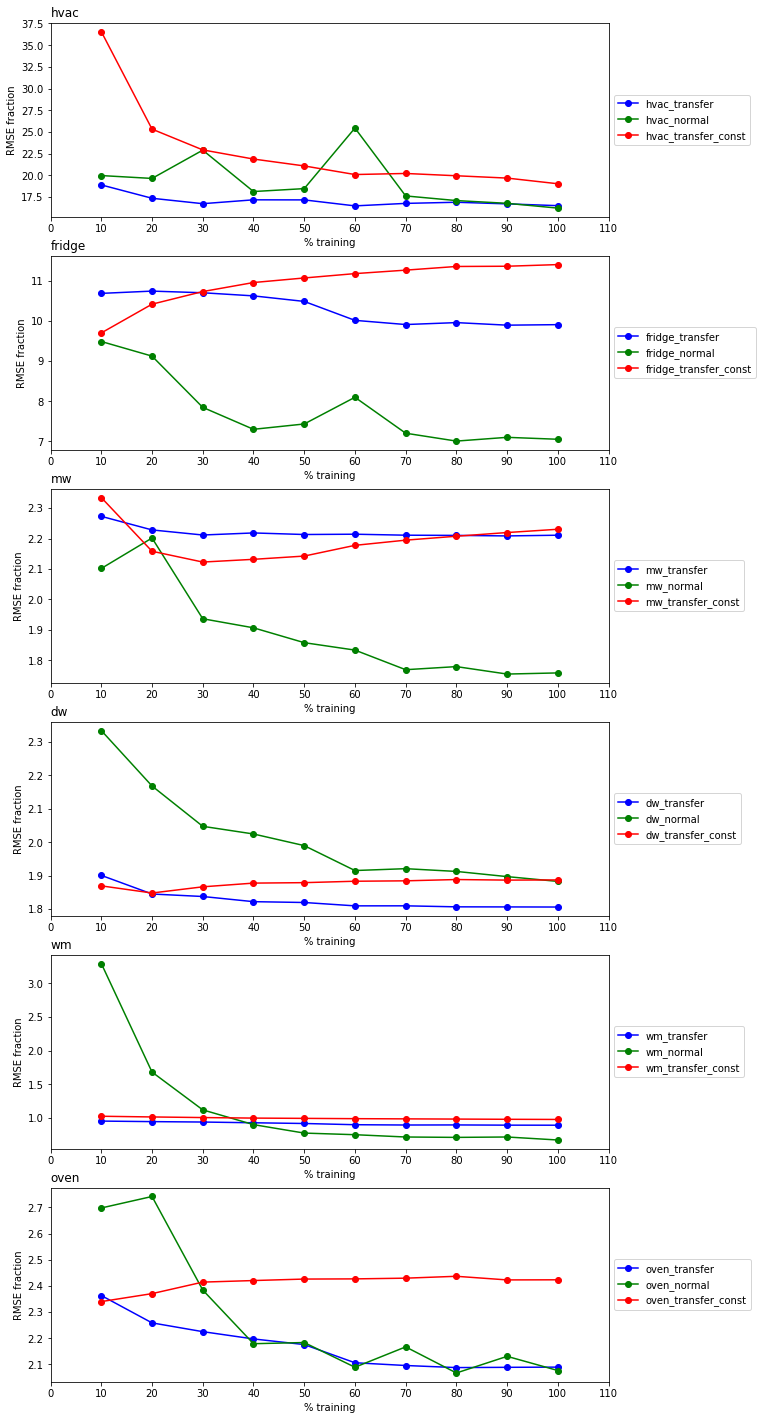

In [106]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 15))
ax = axes.flatten()
count = 0


# df['A'].plot(ax=axes[0,0]); axes[0,0].set_title('A')
for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = all_out[appliance+ '_transfer']
    df2 = all_out[appliance+ '_normal']
    df3 = all_out[appliance+ '_transfer_const']
# df4 = all_out[appliance+ '_agg_2']
# df5 = all_out[appliance+ '_agg_3']
# df6 = all_out[appliance+ '_agg_4']
# df7 = all_out[appliance+ '_reg']
    df = pd.concat([df1, df2, df3], axis=1)
#     ax[count].plot(df)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(10, 25), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_ylabel('RMSE fraction')
    ax[count].set_title(appliance, loc="left")
    count += 1
plt.savefig("./analysis/transfer_const_5.png", bbox_inches="tight", dpi=300)